In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
import datetime
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [70]:
document_vectors_tensor = torch.load('../data/document_vectors_emb_tensor.pt')
labels_tensor = torch.load('../data/labels_emb_tensor.pt')

In [71]:
# Делю данные на тренировочные и тестовые/валидационные
train_data, test_val_data, train_labels, test_val_labels = train_test_split(document_vectors_tensor, labels_tensor, train_size=0.7, random_state=24, stratify=labels_tensor)

In [72]:
# Разделяю тестовые/валидационные на тестовые и валидационные
test_data, val_data, test_labels, val_labels = train_test_split(test_val_data, test_val_labels, train_size=0.5, random_state=24, stratify=test_val_labels)

In [74]:
# Стандартизую данные
mean = torch.mean(train_data, dim=0)
std = torch.std(train_data, dim=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std
val_data = (val_data - mean) / std

In [75]:
# Создаю измерение батчей
train_dataset = TensorDataset(train_data, train_labels)
val_dataset = TensorDataset(val_data, val_labels)
test_dataset = TensorDataset(test_data, test_labels)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [7]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.0):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))

        out = self.fc(out[:, -1, :])
        return out

In [12]:
def training_loop(n_epochs, optimizer, model, criterion, train_loader, val_loader=None):
    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        loss_train = 0.0
        for data, labels in train_loader:
            data = data.unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

        avg_loss_train = loss_train / len(train_loader)
        train_losses.append(avg_loss_train)

        if val_loader is not None:
            val_loss = 0.0
            with torch.no_grad():
                for val_data, val_labels in val_loader:
                    val_data = val_data.unsqueeze(1)
                    val_outputs = model(val_data)
                    val_loss += criterion(val_outputs, val_labels).item()
            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

        # Вывод средней потери на каждой эпохе
        if epoch == 0 or (epoch + 1) % 10 == 0:
            print('{} Epoch {}, Training loss: {:.4f}'.format(
                datetime.datetime.now(), epoch + 1, avg_loss_train))
            if val_loader is not None:
                print('{} Epoch {}, Validation loss: {:.4f}'.format(
                    datetime.datetime.now(), epoch + 1, avg_val_loss))

    return train_losses, val_losses

In [13]:
def plot_losses(train_losses, val_losses=None):
    plt.plot(train_losses, label='Training loss')
    if val_losses:
        plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Losses')
    plt.show()

In [36]:
n_epochs = 15
batch_size = 64
learning_rate = 0.01

model = LSTMClassifier(input_size=100, hidden_size=128, num_layers=2, output_size=6)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [37]:
train_losses, val_losses = training_loop(n_epochs, optimizer, model, criterion, train_loader, val_loader)

2024-03-28 16:18:37.212004 Epoch 1, Training loss: 0.7708
2024-03-28 16:18:37.212145 Epoch 1, Validation loss: 0.7249
2024-03-28 16:20:15.740102 Epoch 10, Training loss: 0.6241
2024-03-28 16:20:15.740214 Epoch 10, Validation loss: 0.6587
2024-03-28 16:22:11.204075 Epoch 20, Training loss: 0.5920
2024-03-28 16:22:11.204181 Epoch 20, Validation loss: 0.6421


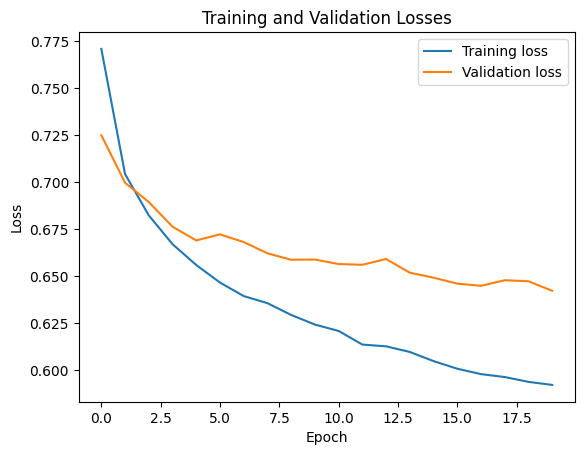

In [38]:
plot_losses(train_losses, val_losses)

In [39]:
val_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for val_data, val_labels in val_loader:
        val_data = val_data.unsqueeze(1)
        val_outputs = model(val_data)
        val_loss += criterion(val_outputs, val_labels).item()
        _, predicted = torch.max(val_outputs, 1)
        total += val_labels.size(0)
        correct += (predicted == val_labels).sum().item()

print('Validation loss: {:.4f}'.format(val_loss / len(val_loader)))
print('Validation accuracy: {:.2f}%'.format(100 * correct / total))

Validation loss: 0.6421
Validation accuracy: 75.38%


In [83]:
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for t_data, t_labels in test_loader:
        t_data = t_data.unsqueeze(1)
        t_outputs = model(t_data)
        test_loss += criterion(t_outputs, t_labels).item()
        _, predicted = torch.max(t_outputs, 1)
        total += t_labels.size(0)
        correct += (predicted == t_labels).sum().item()

print('Test loss: {:.4f}'.format(test_loss / len(test_loader)))
print('Test accuracy: {:.2f}%'.format(100 * correct / total))

Test loss: 0.6494
Test accuracy: 75.27%


In [84]:
model.eval()
predictions = []
with torch.no_grad():
    for data, _ in test_loader:
        outputs = model(data.unsqueeze(1))
        predictions.extend(outputs.tolist())

probs = torch.tensor(predictions)
predicted_classes = torch.argmax(probs, dim=1)

In [85]:
print(classification_report(predicted_classes, test_labels))

              precision    recall  f1-score   support

           0       0.81      0.76      0.78     19353
           1       0.87      0.78      0.82     23496
           2       0.47      0.73      0.57      3363
           3       0.66      0.73      0.69      7843
           4       0.65      0.72      0.68      6459
           5       0.54      0.60      0.57      2003

    accuracy                           0.75     62517
   macro avg       0.67      0.72      0.69     62517
weighted avg       0.77      0.75      0.76     62517


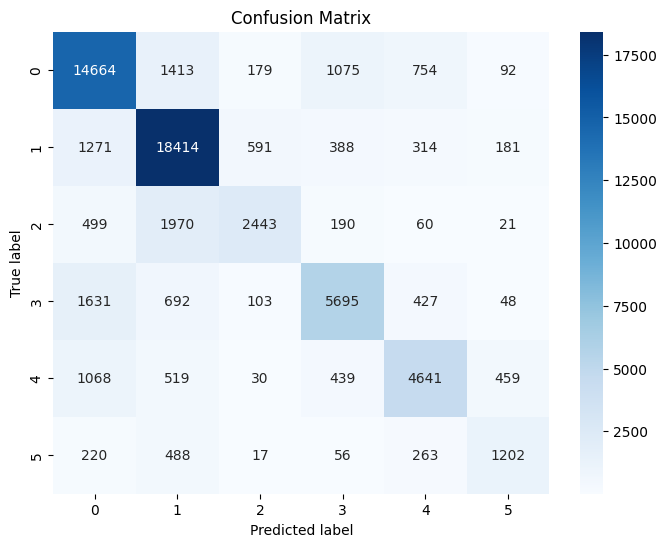

In [86]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()